# Image Colorization

In [1]:
# Project Outline

# 1 Imports
# 2 Data
# 3 Preprocessing 
# 4 Model 
# 5 Training
# 6 Evaluation
# 7 Visualization

In [2]:
# Imports
import numpy as np
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn.functional as F

In [3]:
class ColorizationDataset(Dataset):
    def __init__(self, l_path, ab_paths):
        # Memory-mapped loading (DOES NOT load full files into RAM, instead adds pointer to disk)
        # Essentially a pointer to the file, where loaded 'slices' can be accessed like arr[idx]
       
        # Load L channel (0-255)
        self.l_data = np.load(l_path, mmap_mode="r")

        # Load ab files (0-255)
        self.ab_files = [np.load(path, mmap_mode="r") for path in ab_paths]

        # Combine metadata (pointers to memory-mapped arrays)
        self.ab_data = np.concatenate(self.ab_files, axis=0)

        # Lightness should be in the range of 0 to 100 for absolute black and absolute white respectively 
        print(type(self.l_data))
        print("L channel:", self.l_data.shape)
        print(self.l_data.max())
        print(self.l_data.min())
        
        # AB (Green-Magenta and Blue-Yellow) should be in the range of -128 to 127
        print("AB channel:", self.ab_data.shape)
        print(self.ab_data.max())
        print(self.ab_data.min())

        # Ensure image counts match
        assert self.l_data.shape[0] == self.ab_data.shape[0], "Mismatch in L and ab channel counts"

    def __len__(self):
        return self.l_data.shape[0]
    
    # Load a sample from disk into memory
    def __getitem__(self,idx):
        L = self.l_data[idx]             # shape: (224,224)
        ab = self.ab_data[idx]           # shape: (224,224,2)

        # Convert to Pytorch format (C, H, W)
        # Model expects:
            # L normalized to [0,1]
            # ab normalized to [-1,1]
        L = (L.astype("float32") / 255.0) 
        a = (ab[...,0].astype("float32") - 128) / 128  # 0–255 → -1 to +1
        b = (ab[...,1].astype("float32") - 128) / 128  # 0–255 → -1 to +1

        # Stack normalized AB channels: (H,W,2)
        ab_norm = np.stack([a, b], axis=-1)

        # Convert to channel first (Pytorch formatting again)
        L = L[np.newaxis, :, :]                       # (1,224,224)
        ab_norm = ab_norm.transpose(2, 0, 1)          # (2,224,224)

        # convert numpy arrays into torch.tensor objects
        return {
            'L': torch.tensor(L, dtype=torch.float32),
            'ab': torch.tensor(ab_norm, dtype=torch.float32)
        }
# Data (perhaps should be gradually read in to help with memory)
l_path = "Data/Raw/gray_scale.npy"
ab_paths = ["Data/Raw/ab/ab1.npy", "Data/Raw/ab/ab2.npy", "Data/Raw/ab/ab3.npy"]

# Create dataset
full_dataset = ColorizationDataset(l_path, ab_paths)


<class 'numpy.memmap'>
L channel: (25000, 224, 224)
255
0
AB channel: (25000, 224, 224, 2)
226
20


In [4]:
# Split into train/validation
val_size = int(0.1 * len(full_dataset))     # 10% for validation
train_size = len(full_dataset) - val_size   # 90% for training
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # shuffle to avoid overfitting
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False) # don't shuffle to validate

In [5]:
#function to visualize an image
# convert model output --> RGB
def lab_to_rgb(L_norm, ab_norm):
    # undo normalization
    L = L_norm * 255
    a = ab_norm[...,0] * 128.0 + 128.0

    b = ab_norm[...,1] * 128.0 + 128.0

    #merge channels to create LAB
    lab = np.stack([L, a, b], axis=-1).astype("uint8")

    #convert LAB to color (rgb)
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    rgb = np.clip(rgb / 255, 0, 1)
    return rgb

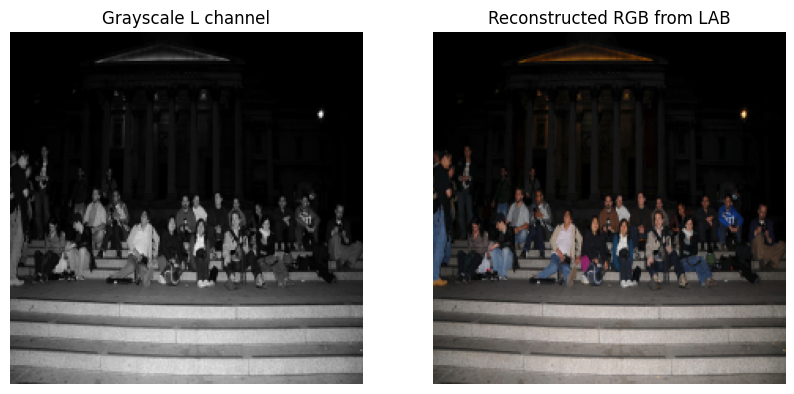

In [6]:
#display sample grayscale image

# Can choose any index
sample = full_dataset[358]      # loads single sample on demand

# Extract L and ab tensors
L_norm = sample['L'].numpy()[0]                   # (1,224,224) -> (244,244)
ab_norm = sample['ab'].numpy().transpose(1,2,0)   # (2,244,244) -> (224,224,2)

# Show the grayscale L channel

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(L_norm, cmap="gray")
plt.title("Grayscale L channel")
plt.axis("off")

# Convert to RGB
rgb = lab_to_rgb(L_norm, ab_norm)

# Visualize
plt.subplot(1,2,2)
plt.imshow(rgb)
plt.title("Reconstructed RGB from LAB")
plt.axis("off")
plt.show()

In [7]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, features=64):
        super().__init__()

        # --------------------
        # ENCODER
        # --------------------
        self.down1 = self._down_block(in_channels, features, batchnorm=False)
        self.down2 = self._down_block(features, features*2)
        self.down3 = self._down_block(features*2, features*4)
        self.down4 = self._down_block(features*4, features*8)
        self.down5 = self._down_block(features*8, features*8)
        self.down6 = self._down_block(features*8, features*8)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4, 2, 1),
            nn.ReLU()
        )

        # --------------------
        # DECODER
        # --------------------
        self.up6 = self._up_block(features*8, features*8, dropout=True, output_padding=1)
        self.up5 = self._up_block(features*16, features*8, dropout=True)
        self.up4 = self._up_block(features*16, features*8)
        self.up3 = self._up_block(features*16, features*4)
        self.up2 = self._up_block(features*8, features*2)
        self.up1 = self._up_block(features*4, features)

        # Final layer
        self.final = nn.Sequential(
            nn.ConvTranspose2d(features*2, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    # -------------------------------------------------------
    # SAFE center crop for skip connections
    # -------------------------------------------------------
    def center_crop(self, skip, target):
        _, _, h, w = target.size()
        skip_h, skip_w = skip.size(2), skip.size(3)
        crop_h = (skip_h - h) // 2
        crop_w = (skip_w - w) // 2
        return skip[:, :, crop_h:crop_h+h, crop_w:crop_w+w]

    def _down_block(self, in_c, out_c, batchnorm=True):
        layers = [nn.Conv2d(in_c, out_c, 4, 2, 1, bias=not batchnorm)]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)

    def _up_block(self, in_c, out_c, dropout=False, output_padding=0):
        layers = [
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, 
                               output_padding=output_padding,
                               bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        ]
        if dropout:
            layers.append(nn.Dropout(0.5))
        return nn.Sequential(*layers)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)

        b = self.bottleneck(d6)

        # Decoder + skip connections (with cropping)
        u6 = self.up6(b)
        d6c = self.center_crop(d6, u6);   u6 = torch.cat([u6, d6c], dim=1)

        u5 = self.up5(u6)
        d5c = self.center_crop(d5, u5);   u5 = torch.cat([u5, d5c], dim=1)

        u4 = self.up4(u5)
        d4c = self.center_crop(d4, u4);   u4 = torch.cat([u4, d4c], dim=1)

        u3 = self.up3(u4)
        d3c = self.center_crop(d3, u3);   u3 = torch.cat([u3, d3c], dim=1)

        u2 = self.up2(u3)
        d2c = self.center_crop(d2, u2);   u2 = torch.cat([u2, d2c], dim=1)

        u1 = self.up1(u2)
        d1c = self.center_crop(d1, u1);   u1 = torch.cat([u1, d1c], dim=1)

        out = self.final(u1)

        # ------------------------
        # Upsample to match input
        # ------------------------
        out = F.interpolate(out, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)

        return out



In [8]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features, features*2, 4, 2, 1),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features*2, features*4, 4, 2, 1),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features*4, features*8, 4, 1, 1),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features*8, 1, 4, 1, 1)  # output patch map
        )

    def forward(self, x):
        return self.net(x)


In [9]:


def train_cgan(generator, discriminator, train_loader, val_loader, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generator = generator.to(device)
    discriminator = discriminator.to(device)

    opt_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    opt_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

    bce = nn.BCEWithLogitsLoss()
    l1 = nn.L1Loss()
    lambda_l1 = 100

    for epoch in range(1, epochs+1):
        generator.train()
        discriminator.train()

        for batch in train_loader:
            L = batch["L"].to(device)          # (B,1,H,W)
            ab = batch["ab"].to(device)        # (B,2,H,W)

            # ----------------------
            # Train Discriminator
            # ----------------------
            opt_D.zero_grad()

            fake_ab = generator(L)
            fake_pair = torch.cat([L, fake_ab.detach()], dim=1)
            real_pair = torch.cat([L, ab], dim=1)

            pred_fake = discriminator(fake_pair)
            pred_real = discriminator(real_pair)

            loss_D_fake = bce(pred_fake, torch.zeros_like(pred_fake))
            loss_D_real = bce(pred_real, torch.ones_like(pred_real))
            loss_D = (loss_D_fake + loss_D_real) * 0.5
            loss_D.backward()
            opt_D.step()

            # ----------------------
            # Train Generator
            # ----------------------
            opt_G.zero_grad()

            fake_ab = generator(L)
            fake_pair = torch.cat([L, fake_ab], dim=1)
            pred_fake = discriminator(fake_pair)

            adv_loss = bce(pred_fake, torch.ones_like(pred_fake))
            l1_loss = l1(fake_ab, ab)

            loss_G = adv_loss + lambda_l1 * l1_loss
            loss_G.backward()
            opt_G.step()

        print(f"Epoch {epoch}/{epochs} | G: {loss_G.item():.4f}, D: {loss_D.item():.4f}")


In [10]:
def show_prediction(generator, dataset, idx=0):
    generator.eval()
    sample = dataset[idx]

    L = sample["L"].unsqueeze(0).to(next(generator.parameters()).device)
    ab_true = sample["ab"]

    with torch.no_grad():
        ab_pred = generator(L).cpu()[0]

    # Convert to numpy for LAB-to-RGB
    L_np = L.cpu()[0].squeeze().numpy()
    ab_pred_np = ab_pred.permute(1,2,0).numpy()
    ab_true_np = ab_true.permute(1,2,0).numpy()

    rgb_pred = lab_to_rgb(L_np, ab_pred_np)
    rgb_true = lab_to_rgb(L_np, ab_true_np)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(L_np, cmap="gray"); plt.title("L"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(rgb_true); plt.title("True"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(rgb_pred); plt.title("Predicted"); plt.axis("off")
    plt.show()


In [ ]:

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

print(torch.version.cuda)        # Shows which CUDA PyTorch was built for
print(torch.backends.cudnn.enabled)  # Should be True
print(torch.cuda.is_available())     # Should be True if GPU works

#if you get False it'll use CPU which will take a long time so uninstall torch and reinstall correct version for your system from here: https://pytorch.org/get-started/locally/

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = UNetGenerator().to(device)
disc = PatchDiscriminator().to(device)

#this takes 30 minutes and makes my laptop sound like an airplane and makes runs my battery like hell just fyi
train_cgan(gen, disc, train_loader, val_loader, epochs=5)


CUDA available: True
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU
12.6
True
True
Epoch 1/5 | G: 13.6290, D: 0.1633
Epoch 2/5 | G: 21.2757, D: 0.0056
Epoch 3/5 | G: 15.9184, D: 0.0112
Epoch 4/5 | G: 18.6332, D: 0.0076
Epoch 5/5 | G: 6.6784, D: 1.1041


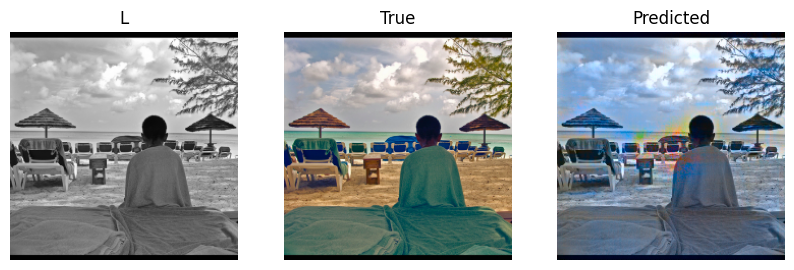

In [13]:
show_prediction(gen, full_dataset, idx=135)

